## Approximating the Volatility Smile

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import math
import deribit_data as dm
import datetime

The following example was adapted from the excellent book, "FX Derivatives Trader School" by Giles Jewitt. It is a comprehensive resource on how institutional traders manage and price risk in FX option markets. Below we will approximate a volatility smile curve for Bitcoin options using an approximation method presented in [Allan M. Malz (1997)](https://www.newyorkfed.org/medialibrary/media/research/staff_reports/sr32.html).

#### Key Terms

- **Implied Volatility (IV)**: The market's forecast of volatility during the course of an option's life
- **ATM (At the Money)**: The IV for a specific strike close to the price of the underlying asset
- **Fly (Butterfly)**: The IV difference between wings of volatility smile and the ATM IV (this measures the height of the wings of the volatility smile)
- **Risk Reversal (RR)**: The IV differential between strikes above and below ATM (this measures the skewness of the volatility smile)

#### Model Parameters

- $\sigma_{Call25d} = \text{25 Delta Call IV}$
- $\sigma_{Put25d} = \text{25 Delta Put IV}$
- $\sigma_{ATM} = \text{ATM IV}$
- $\sigma_{RR25d} = \text{25 Delta Risk Reversal IV}$
- $\sigma_{FLY25d} = \text{25 Delta Butterfly IV}$
- $ \sigma_{X Delta Put} = \text{Delta Put IV}$
- $X = \text{absolute value of the put option delta}$

##### Malz Put Option Implied Volatility Approximation

$ \sigma_{Call25d} = \sigma_{ATM} + \sigma_{Fly25d} + \frac{1}{2}\sigma_{RR25d}$

$ \sigma_{Put25d} = \sigma_{ATM} + \sigma_{Fly25d} - \frac{1}{2}\sigma_{RR25d}$

$ \sigma_{RR25d} = \sigma_{Call25d} - \sigma_{Put25d} $

$ \sigma_{FLY25d} = \frac{(\sigma_{Call25d} + \sigma_{Put25d})}{2} - \sigma_{ATM} $

$ \sigma_{X Delta Put} = \sigma_{ATM} + 2\cdot\sigma_{RR25d}\cdot(X - 50\%) +16\cdot\sigma_{FLY25d}\cdot(X-50\%)^2$

Source: FX Derivatives Trader School: Pg. 206

In [196]:
# Load and select relevant options data from CSV file
df = pd.read_csv("options_data.csv", index_col=0)
greeks = pd.DataFrame(df.greeks.apply(ast.literal_eval).tolist())
df = df[['option_type', 'instrument_name', 'strike', 'mark_iv', 'bid_iv', 'ask_iv', 
         'underlying_price', 'expiration_timestamp']]
df = pd.concat([df, greeks], axis=1)

# Select earliest maturity option contract for our analysis
maturities = list(set(df.expiration_timestamp))
df = df[df.expiration_timestamp==maturities[0]]

# Seperate out calls and puts
# We will also use mid-implied volatility for our analysis
df['mid_iv'] = (df.bid_iv + df.ask_iv)/2
calls = df[df.option_type == 'call']
puts = df[df.option_type == 'put']
calls['delta'] = ((calls.delta)*100).round(-1)
puts['delta'] = (abs(puts.delta)*100).round(-1)

In [202]:
# Calculate ATM volatility - note: ATM is calculated based on: (current average_price +/- $10)
avg_price = round(df.underlying_price.mean())
atm_iv = df[(df.strike.values >= avg_price -10) & (df.strike.values <= avg_price +10)].mid_iv.mean()

# Select options with average of 25 delta (ranges from 20 to 30)
put_25D_iv = puts[(puts.delta == 20) | (puts.delta == 30)].mid_iv.mean()
call_25D_iv = calls[(calls.delta == 20) | (calls.delta == 30)].mid_iv.mean()

# Risk reversal implied volatility calculation
rr25D_iv = call_25D_iv - put_25D_iv

# Butterfly implied volatility calculation
fly25D_iv = (call_25D_iv + put_25D_iv)/2 - atm_iv

In [203]:
def put_delta_iv(delta, rr, fly, atm):
    '''Malz Approximation: approximates the volatility smile'''
    return(atm + 2*rr*(delta-0.50) + 16*fly*((delta-0.50))**2)

In [204]:
# Generate the volatility smile approximations
put_delta_aprx = [put_delta_iv(i, rr25D_iv, fly25D_iv, atm_iv) for i in np.arange(0.01, 1, 0.01)]
put_delta_aprx = [0 if math.isnan(x) else x for x in put_delta_aprx]

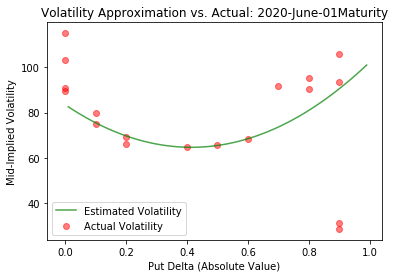

In [205]:
sorted_puts = puts.sort_values('delta')
plt.plot(np.arange(0.01, 1, 0.01), put_delta_aprx, c='g', alpha=0.70, label='Estimated Volatility')
plt.scatter(sorted_puts.delta/100, sorted_puts.mid_iv, c='r', alpha=0.50, label='Actual Volatility')
plt.xlabel("Put Delta (Absolute Value)")
plt.ylabel("Mid-Implied Volatility")
option_date = datetime.datetime.fromtimestamp(maturities[mat]/1000).strftime('%Y-%B-%d')
plt.title("Volatility Approximation vs. Actual: " + option_date + "Maturity")
plt.legend();
plt.show()

Conclusion: Not practical in real-world trading due to many theoretical assumptions but a good starting framework to get rolling.